# Calcium Imaging - Neuron Detection Project
Guy Teichman & Moran Neuhof, Winter 2019

In [1]:
from Segmentation.params import *
from Segmentation.utilities import *
from Segmentation.processing_funcs import *
from Segmentation.kmeans import *
from Segmentation.evaluate import *
from Segmentation.cellFluor import *

%matplotlib inline

### Loading images and masks

In [2]:
# load the images
files = sorted(glob(imgs_path))
imgs = np.array([imread(f) for f in files])
dims = imgs.shape[1:]

masks = plotregions(regions_file, dims)
summed = np.float64(imgs.sum(axis=0))
# removed artifact
imgf = np.concatenate((imgs[0:2060,:,:], imgs[2250:,:,:]), axis=0)  
summedf = np.float64(imgf.sum(axis=0))


C:\Users\t-moneuh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Filter each pixel based on the time series

In [3]:
# Creating a list of filters and their parameters
filter_methods = [(ndimage.gaussian_filter1d, 4)]
# Filtering each pixel's change in fluorescence over time
ts_filtered_imgs = filter_timeseries(np.float64(imgf), filter_methods)

Running 1 timelapse filtering methods.


### Calculate Pearson correlation after filtering time series

In [4]:
neighborCorrcoef = correlate_neighbors(ts_filtered_imgs[0][0])

Progress: 10000/262144 (3.81%)
Progress: 20000/262144 (7.63%)
Progress: 30000/262144 (11.44%)
Progress: 40000/262144 (15.26%)
Progress: 50000/262144 (19.07%)
Progress: 60000/262144 (22.89%)
Progress: 70000/262144 (26.70%)
Progress: 80000/262144 (30.52%)
Progress: 90000/262144 (34.33%)
Progress: 100000/262144 (38.15%)
Progress: 110000/262144 (41.96%)
Progress: 120000/262144 (45.78%)
Progress: 130000/262144 (49.59%)
Progress: 140000/262144 (53.41%)
Progress: 150000/262144 (57.22%)
Progress: 160000/262144 (61.04%)
Progress: 170000/262144 (64.85%)
Progress: 180000/262144 (68.66%)
Progress: 190000/262144 (72.48%)
Progress: 200000/262144 (76.29%)
Progress: 210000/262144 (80.11%)
Progress: 220000/262144 (83.92%)
Progress: 230000/262144 (87.74%)
Progress: 240000/262144 (91.55%)
Progress: 250000/262144 (95.37%)
Progress: 260000/262144 (99.18%)


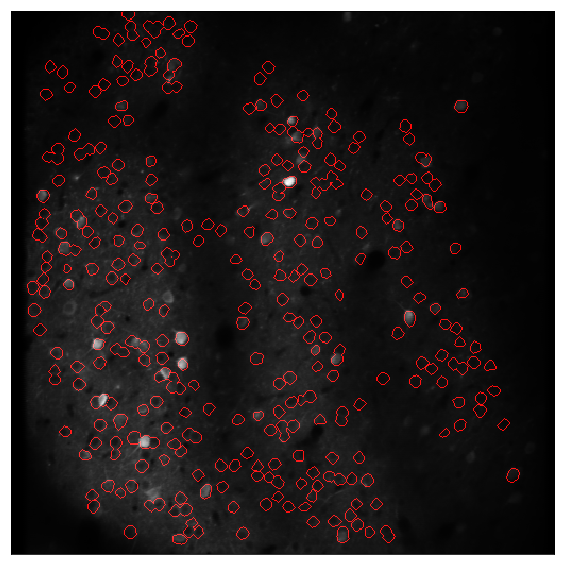

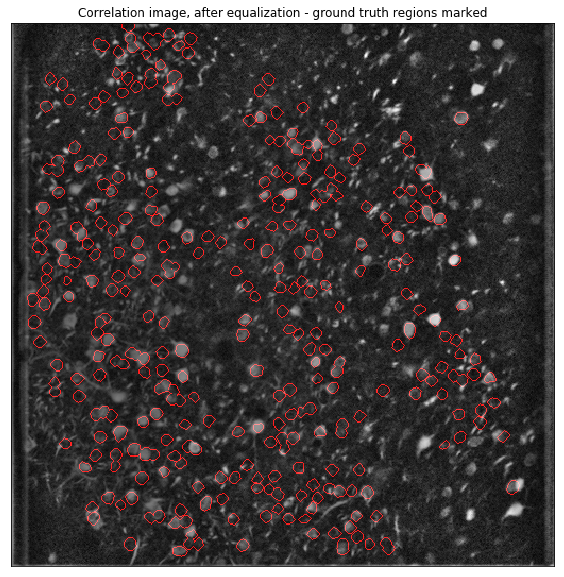

In [19]:
cont = find_contours(masks.sum(axis=0))  # contours 
show(draw_circles(summed,cont))
corrcoef_norm = norm_data(neighborCorrcoef)  # normalization

# remove background
corrcoef_norm_eq = corrcoef_norm/ndimage.gaussian_filter(corrcoef_norm,sigma=15)
show(draw_circles(corrcoef_norm_eq, cont))
plt.title("Correlation image, after equalization - ground truth regions marked");

#### Remove the image frame

In [20]:
# removing edges
corrcoef_norm_eq_no_frame = corrcoef_norm_eq.copy()
corrcoef_norm_eq_no_frame[:, 0:18] = 0
corrcoef_norm_eq_no_frame[:, -12:] = 0

In [21]:
# removing background from the original summed image
summed_eq = summed / ndimage.gaussian_filter(summed, sigma=15)

### Kmeans and remove background

In [22]:
# Kmeans on the image with no frame
K=16
segmented_data_no_frame, thresholds, centroids = kmeans_with_centroids(corrcoef_norm_eq_no_frame, K)
# Remove background, using kmeans
seg_no_frame = segmented_data_no_frame.copy()
seg_no_frame[seg_no_frame <= thresholds[8]] = 0

### Creating boolean image, as seeds for watershed

In [23]:
bool_img = morphology.erosion(seg_no_frame, morphology.disk(1)) > 0

### Adding Hit or Miss for donut neurons

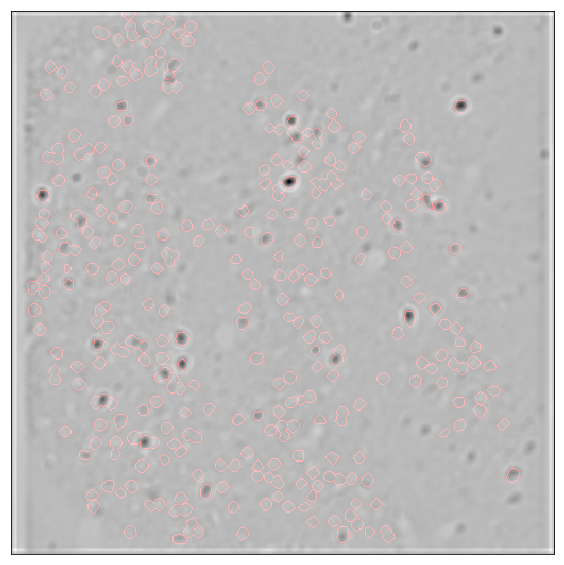

In [24]:
# show(hitormiss_donut(new_summed))
hms = norm_data(hitormiss_donut(summed_eq))
show(draw_circles(norm_data(hitormiss_donut(summed_eq)),cont))
hms_labeled = ndimage.label((hms>0.75)&(hms<0.89))[0]
hms_selected = size_selection(hms_labeled, 10, 0)

In [25]:
comb_bool_img = bool_img | morphology.erosion((hms_selected > 0),morphology.disk(1))

{'combined': 0.3831, 'inclusion': 0.6832, 'precision': 0.3579, 'recall': 0.4121, 'exclusion': 0.6227}


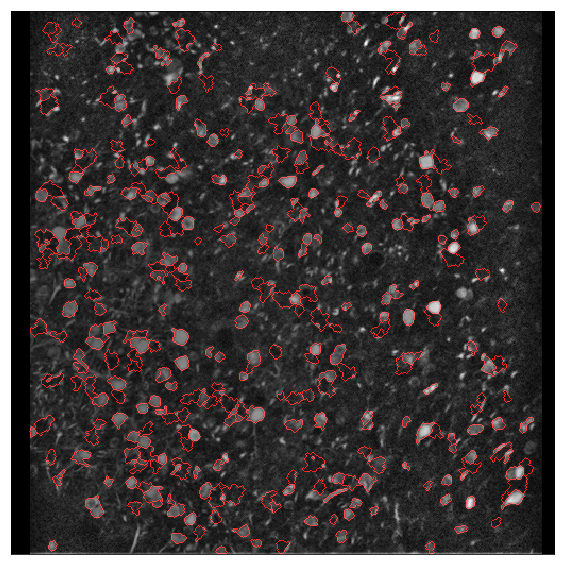

In [26]:
size_selected_after_ws = watershed(corrcoef_norm_eq_no_frame , comb_bool_img, 'neuron_detection_final', dims, dial_rad=8, max_neuron_size=21, min_neuron_size=5)
img_w_contours = draw_circles(corrcoef_norm_eq_no_frame, find_contours(size_selected_after_ws))
show(img_w_contours)
print(evaluation('neuron_detection_final'))

In [27]:
# save_image(img_w_contours, 'final_regions.jpg')
im = Image.fromarray(img_w_contours)
im.save('final_regions_190221.jpg')

# saving parameters
np.save('corrcoef_norm_eq_no_frame_final.npy', corrcoef_norm_eq_no_frame)
np.save('summed_eq_final.npy', summed_eq)
np.save('seg_no_frame_final.npy', seg_no_frame)

### Grid search over parameters
#### DO NOT RUN

In [ ]:
# Grid search on the following:
# show(hitormiss_donut(new_summed))
grid_search_res = []
bool_img_disk_range1 = range(1,2)
rad_inner_range = range(4,7)
width_range = range(2,4)
hms_max_size_range = range(8, 13)
# thresholds
hms_labeling_threshold_min_range = range(73, 76)
hms_labeling_threshold_max_range = range(86, 91)
bool_img_disk_range2 = range(1,2)

max_size_range = range(21, 24)
min_size_range = range(4, 7)
dial_rad_range = range(6, 10)

img_tuple = (corrcoef_norm_eq_no_frame, summed_eq)

# old parameters:
# bool_img_disk_range1 = range(1,4)
# rad_inner_range = range(3,8)
# width_range = range(1,5)
# hms_max_size_range = range(7, 16)
# # thresholds
# hms_labeling_threshold_min_range = range(71, 79)
# hms_labeling_threshold_max_range = range(84, 93)
# bool_img_disk_range2 = range(1,4)

# max_size_range = range(18, 25)
# min_size_range = range(3,7)
# dial_rad_range = range(5, 15)

# img_tuple = (corrcoef_norm_eq_no_frame, summed_eq)

total_counts = count_combs([bool_img_disk_range1, rad_inner_range, width_range, hms_max_size_range, 
                            hms_labeling_threshold_min_range, hms_labeling_threshold_max_range, bool_img_disk_range2,
                            max_size_range, min_size_range, dial_rad_range,img_tuple])
print(f"Trying {total_counts} combinations")
start_time = time.time()
print(f"Started at {time.strftime('%H:%M:%S', time.gmtime(start_time))}")
dict_for_bad_eval = {x: 0 for x in ('combined', 'inclusion', 'precision', 'recall', 'exclusion')}  # if eval fails

counter = 0
for bool_img_disk_size1 in bool_img_disk_range1:
    bool_img = morphology.erosion(seg_no_frame, morphology.disk(bool_img_disk_size1)) > 0
    # hit or miss
    for rad_inner in rad_inner_range:  # positive radius
        for width in width_range:  # negative radius
            if rad_inner + width >= 12:  # bigger than the neuron radius
                continue  # ignore
            hms = norm_data(hitormiss_donut(summed_eq, rad_inner, width))
            # show(draw_circles(hms, cont))
            # hms_with_cont = draw_circles(hms, cont)
            for min_threshold in hms_labeling_threshold_min_range:
                min_threshold /= 100
                for max_threshold in hms_labeling_threshold_max_range:
                    max_threshold /= 100
                    hms_labeled = ndimage.label(((min_threshold < hms) & (hms < max_threshold)))[0]  # between thresholds
                    # show(hms_labeled)
                    for hms_max_size in hms_max_size_range:
                        hms_selected = size_selection(hms_labeled, hms_max_size, 0)  # selecting smaller neurons
                        hms_selected_bool = hms_selected > 0
                        for bool_img_disk_size2 in bool_img_disk_range2:
                            bool_img2 = morphology.erosion(hms_selected_bool, morphology.disk(bool_img_disk_size2))
                            comb_bool_img = bool_img | bool_img2
                            for dial_rad in dial_rad_range:
                                for max_neuron_size in max_size_range:
                                    for min_neuron_size in min_size_range:
                                        for i, img in enumerate(img_tuple):
                                            json_fname = "grid_search_json"
                                            size_selected_after_ws = watershed(img, comb_bool_img, json_fname, dims, dial_rad=dial_rad, max_neuron_size=max_neuron_size, min_neuron_size=min_neuron_size)
                                            if size_selected_after_ws is None:  # if size selection didn't keep anything
                                                d = {"bool_img_disk_size1": bool_img_disk_size1,
                                                 "rad_inner": rad_inner,
                                                 "width": width,
                                                 "min_threshold": min_threshold,
                                                 "max_threshold": max_threshold,
                                                 "hms_max_size": hms_max_size,
                                                 "bool_img_disk_size2": bool_img_disk_size2,
                                                 "dial_rad": dial_rad,
                                                 "max_neuron_size": max_neuron_size,
                                                 "min_neuron_size": min_neuron_size,
                                                 "img": i,
                                                 "evaluation": dict_for_bad_eval
                                                }
                                            else:
                                                # img_w_contours = draw_circles(corrcoef_norm_eq_no_frame, find_contours(size_selected_after_ws))
                                                # show(img_w_contours)
                                                evaluation_res = evaluation(json_fname)
                                                
                                                d = {"bool_img_disk_size1": bool_img_disk_size1,
                                                     "rad_inner": rad_inner,
                                                     "width": width,
                                                     "min_threshold": min_threshold,
                                                     "max_threshold": max_threshold,
                                                     "hms_max_size": hms_max_size,
                                                     "bool_img_disk_size2": bool_img_disk_size2,
                                                     "dial_rad": dial_rad,
                                                     "max_neuron_size": max_neuron_size,
                                                     "min_neuron_size": min_neuron_size,
                                                     "img": i,
                                                     "evaluation": evaluation_res
                                                    }
                                            grid_search_res.append(d)
                                            os.remove(fix_json_fname(json_fname))
                                            # counter
                                            counter += 1
                                            if counter % 100 == 0:
                                                elapsed_time = time.time() - start_time                                                
                                                print(f"Progress: {counter}/{total_counts} ({counter/total_counts * 100:.2f}%). Elapsed: {time.strftime('%H:%M:%S', elapsed_time)}")
                                            # once in 100:
                                            if counter % 1000 == 0:
                                                # with open('res_last.pickle', 'wb') as f:  # used to be
                                                with open('res_last_2.pickle', 'wb') as f:
                                                    # Pickle the 'data' dictionary using the highest protocol available.
                                                    pickle.dump(grid_search_res, f, pickle.HIGHEST_PROTOCOL)
                                                    print("Results pickled")

Trying 32400 combinations
Started at 21:01:46
Progress: 100/32400 (0.31%). Elapsed: 00:03:32
Progress: 200/32400 (0.62%). Elapsed: 00:07:17
Progress: 300/32400 (0.93%). Elapsed: 00:10:36
Progress: 400/32400 (1.23%). Elapsed: 00:13:54
Progress: 500/32400 (1.54%). Elapsed: 00:17:14
Progress: 600/32400 (1.85%). Elapsed: 00:20:34
Progress: 700/32400 (2.16%). Elapsed: 00:23:56
Progress: 800/32400 (2.47%). Elapsed: 00:27:18
Progress: 900/32400 (2.78%). Elapsed: 00:30:51
Progress: 1000/32400 (3.09%). Elapsed: 00:34:29
Results pickled
Progress: 1100/32400 (3.40%). Elapsed: 00:37:51
Progress: 1200/32400 (3.70%). Elapsed: 00:41:22
Progress: 1300/32400 (4.01%). Elapsed: 00:44:48
Progress: 1400/32400 (4.32%). Elapsed: 00:48:14
Progress: 1500/32400 (4.63%). Elapsed: 00:51:38
Progress: 1600/32400 (4.94%). Elapsed: 00:55:04
Progress: 1700/32400 (5.25%). Elapsed: 00:58:32
Progress: 1800/32400 (5.56%). Elapsed: 01:01:52
Progress: 1900/32400 (5.86%). Elapsed: 01:05:10
Progress: 2000/32400 (6.17%). Elaps

Progress: 16200/32400 (50.00%). Elapsed: 09:46:04
Progress: 16300/32400 (50.31%). Elapsed: 09:49:22
Progress: 16400/32400 (50.62%). Elapsed: 09:52:40
Progress: 16500/32400 (50.93%). Elapsed: 09:56:00
Progress: 16600/32400 (51.23%). Elapsed: 09:59:18
Progress: 16700/32400 (51.54%). Elapsed: 10:02:36
Progress: 16800/32400 (51.85%). Elapsed: 10:05:55
Progress: 16900/32400 (52.16%). Elapsed: 10:09:15
Progress: 17000/32400 (52.47%). Elapsed: 10:12:34
Results pickled
Progress: 17100/32400 (52.78%). Elapsed: 10:15:51
Progress: 17200/32400 (53.09%). Elapsed: 10:19:10
Progress: 17300/32400 (53.40%). Elapsed: 10:22:28
Progress: 17400/32400 (53.70%). Elapsed: 10:25:48
Progress: 17500/32400 (54.01%). Elapsed: 10:29:07
Progress: 17600/32400 (54.32%). Elapsed: 10:32:25
Progress: 17700/32400 (54.63%). Elapsed: 10:35:44
Progress: 17800/32400 (54.94%). Elapsed: 10:39:05
Progress: 17900/32400 (55.25%). Elapsed: 10:42:24
Progress: 18000/32400 (55.56%). Elapsed: 10:45:46
Results pickled
Progress: 18100/32

In [ ]:
print(f"Finished at {time.strftime('%H:%M:%S', time.gmtime(start_time))}")
with open('res_last_2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(grid_search_res, f, pickle.HIGHEST_PROTOCOL)
    print("Results pickled")

## Plotting fluorescence

### Plotting the results achieved by our pipeline on the same dataset


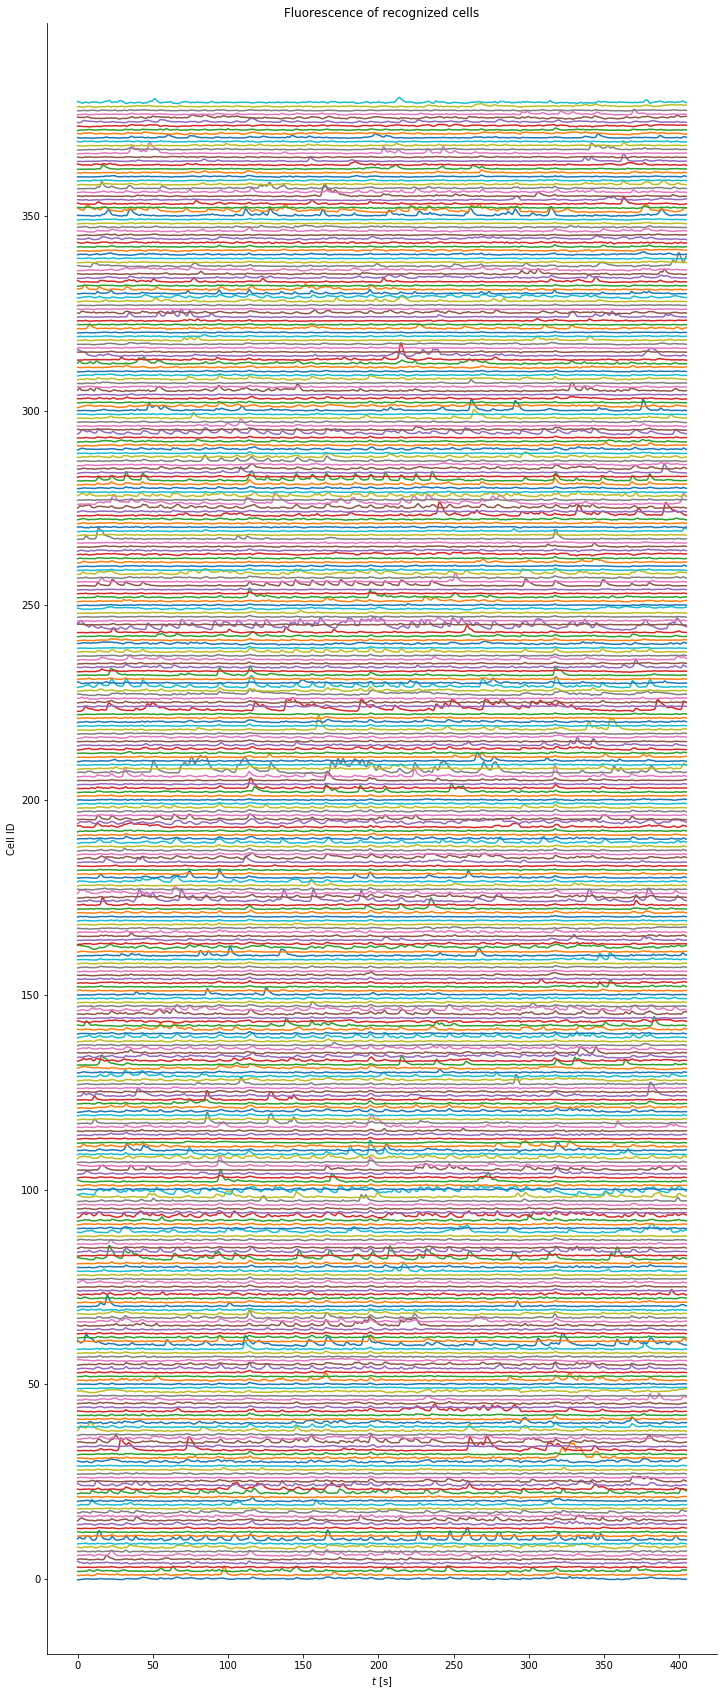

In [28]:
# plot fluorescence
activity = plotCellFluorescence(ts_filtered_imgs[0][0], 'neuron_detection_final', figsize=(12,30), neuron_lim=None)

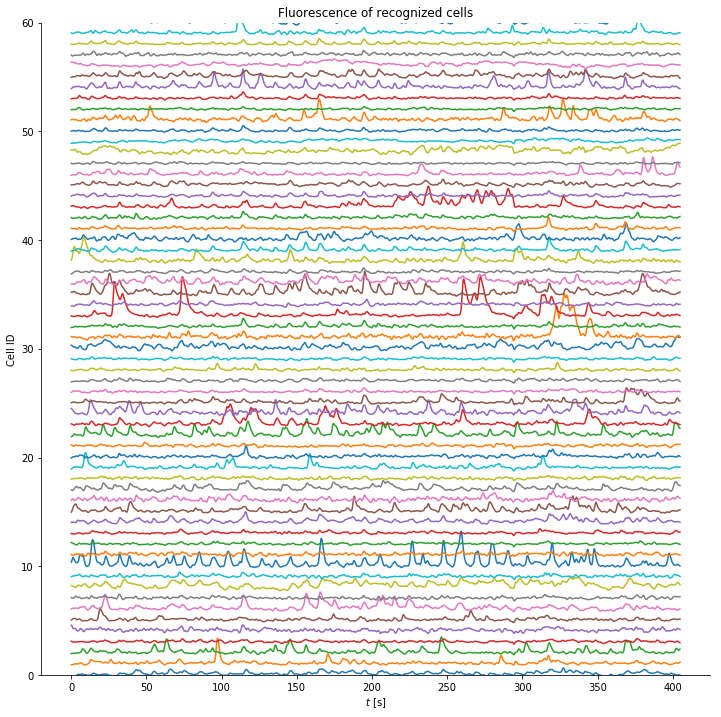

In [29]:
# plot fluorescence
activity = plotCellFluorescence(ts_filtered_imgs[0][0], 'neuron_detection_final', neuron_lim=(0,60))